In [134]:
import sys
sys.path.append('../')
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M, MobileNetV3Small, MobileNetV2 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import TrainDataPrepare as td
import HelperFunctions as hf

sys.path.remove('../')


pd.set_option('display.max_rows', 100)  # Increase the number of rows
pd.set_option('display.max_columns', 20)  # Increase the number of columns
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', None) 

In [135]:
LEARNING_RATE = 0.001
PREPARE_DATA = True
USE_SYNTHETIC_DATA = True
SYNTHETIC_DATA_DIR = ''
LOAD_ALREADY_MODEL = False

images_train = '../prepared_data/train'
images_val = '../prepared_data/val'
images_test = '../prepared_data/test'
train_csv_path = '../prepared_data/train_dataset.csv'
val_csv_path = '../prepared_data/val_dataset.csv'
test_csv_path = '../prepared_data/test_dataset.csv'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 150
REAL_DATA_PERCENT = 100
SYNTHETIC_DATA_PERCENT = 75
SIN_DIR = '../synthetic_data_0.15/train'
MODEL_NAME = 'MobileNetV2'
SYN_HALU = '0.15'

In [136]:
if (PREPARE_DATA):
    #prepare csv
    #prepare data for traning and place them into prepared_data folder
    td.SelectDataByPercent('../OOC_image_dataset/train', '../prepared_data/train', REAL_DATA_PERCENT)
    td.SelectDataByPercent(SIN_DIR, '../prepared_data/train', SYNTHETIC_DATA_PERCENT)

    #transform xlsx file to csv 
    hf.convert_xlsx_to_csv('../OOC_datasheet.xlsx', '../OOC_datasheet.csv')

    #create csv file also for sythetic data 
    td.create_synthetic_csv_from_real_and_structure('../OOC_datasheet.csv', SIN_DIR, '../OOC_datasheet_01.csv')

    #join both csv files toghether
    hf.concatenate_csv('../OOC_datasheet.csv', '../OOC_datasheet_01.csv', '../OOC_datasheet_joined.csv')
    hf.delete_file('../OOC_datasheet.csv')
    hf.delete_file('../OOC_datasheet_01.csv')

    #transfer val and test datasets to prepared data
    hf.copy_directory('../OOC_image_dataset/test/', '../prepared_data')
    hf.copy_directory('../OOC_image_dataset/val/', '../prepared_data')

    #split the csv files into train, val, test
    hf.split_datasets_by_actual_images('../OOC_datasheet_joined.csv', '../prepared_data', '../prepared_data')
    hf.delete_file('../OOC_datasheet_joined.csv')

Headers in the CSV: ['imageID', 'cell type', 'seeding density, cells/ml', 'time after seeding, h', 'day', 'Decision 1/2 (good/bad)', 'flow rate']
Deleted: ../OOC_datasheet.csv
Deleted: ../OOC_datasheet_01.csv
Copied 'c:\Users\Roberts\Documents\repos\Bakalaurs\OOC_image_dataset\test' to 'c:\Users\Roberts\Documents\repos\Bakalaurs\prepared_data\test' successfully.
Copied 'c:\Users\Roberts\Documents\repos\Bakalaurs\OOC_image_dataset\val' to 'c:\Users\Roberts\Documents\repos\Bakalaurs\prepared_data\val' successfully.
Collected 7880 image paths.
Filtered dataset contains 7880 records.
Train data saved to ../prepared_data\train_dataset.csv
Val data saved to ../prepared_data\val_dataset.csv
Test data saved to ../prepared_data\test_dataset.csv
Deleted: ../OOC_datasheet_joined.csv


In [137]:
images_train = '../prepared_data/train'
images_val = '../prepared_data/val'
images_test = '../prepared_data/test'
train_csv_path = '../prepared_data/train_dataset.csv'
val_csv_path = '../prepared_data/val_dataset.csv'
test_csv_path = '../prepared_data/test_dataset.csv'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

In [138]:
def collect_image_paths(dataset_type):
    paths = []
    for decision in ['good', 'bad']:
        decision_base_path = os.path.join('../prepared_data', dataset_type, decision)
        for cell_type in os.listdir(decision_base_path):
            cell_type_path = os.path.join(decision_base_path, cell_type)
            if os.path.isdir(cell_type_path):
                for day_dir in os.listdir(cell_type_path):
                    day_path = os.path.join(cell_type_path, day_dir)
                    if os.path.isdir(day_path):
                        for file in os.listdir(day_path):
                            if file.endswith('.png'):
                                paths.append(os.path.join(day_path, file))
    return paths

train_paths = collect_image_paths('train')
val_paths = collect_image_paths('val')
test_paths = collect_image_paths('test')

def map_image_paths(df, image_paths):
    path_dict = {os.path.splitext(os.path.basename(path))[0]: path for path in image_paths}
    df['image_path'] = df['imageID'].map(path_dict)
    return df



# Map the collected paths to the DataFrame based on the imageID
train_df = map_image_paths(train_df, train_paths)
val_df = map_image_paths(val_df, val_paths)
test_df = map_image_paths(test_df, test_paths)

train_df['label'] = train_df['Decision 1/2 (good/bad)'].map({1: 'Good', 2: 'Bad'})
val_df['label'] = val_df['Decision 1/2 (good/bad)'].map({1: 'Good', 2: 'Bad'})
test_df['label'] = test_df['Decision 1/2 (good/bad)'].map({1: 'Good', 2: 'Bad'})


In [139]:
print(train_df)

                    imageID cell type seeding density, cells/ml  time after seeding, h  day  Decision 1/2 (good/bad) flow rate                                                                  image_path label
0                 220429_01     HPMEC              5,000,000.00                    0.0    1                        1       NaN          ../prepared_data\train\good\cell_type_HPMEC\0-1_days\220429_01.png  Good
1                 220429_02     HPMEC              5,000,000.00                    0.0    1                        1       NaN          ../prepared_data\train\good\cell_type_HPMEC\0-1_days\220429_02.png  Good
2                 220429_04     HPMEC              5,000,000.00                    0.0    1                        2       NaN           ../prepared_data\train\bad\cell_type_HPMEC\0-1_days\220429_04.png   Bad
3                 220429_06     HPMEC              5,000,000.00                    0.0    1                        1       NaN          ../prepared_data\train\good\

In [140]:
# datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True)
# val_datagen = ImageDataGenerator(rescale=1.0/255)


# def create_generator(dataframe, batch_size, target_size, shuffle=True, class_mode='binary'):
#     return datagen.flow_from_dataframe(
#         dataframe,
#         #directory='image_path',
#         x_col='image_path',
#         y_col='label',
#         target_size=target_size,
#         batch_size=batch_size,
#         shuffle=shuffle,
#         class_mode=class_mode
#     )


# train_generator = create_generator(train_df, BATCH_SIZE, IMAGE_SIZE)
# val_generator = create_generator(val_df, BATCH_SIZE, IMAGE_SIZE, shuffle=False)
# test_generator = create_generator(test_df, BATCH_SIZE, IMAGE_SIZE, shuffle=False)

train_datagen = ImageDataGenerator(rescale = 1./255.,
                            #    rotation_range = 40,
                            #    width_shift_range = 0.2,
                            #    height_shift_range = 0.2,
                            #    shear_range = 0.2,
                            #    zoom_range = 0.2,
                               horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode='binary'
    )  

# Flow validation images in batches of 20 using test_datagen generator
val_generator =  test_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode='binary'
    )                          

test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode='binary'
    )  

Found 6938 validated image filenames belonging to 2 classes.
Found 286 validated image filenames belonging to 2 classes.
Found 656 validated image filenames belonging to 2 classes.


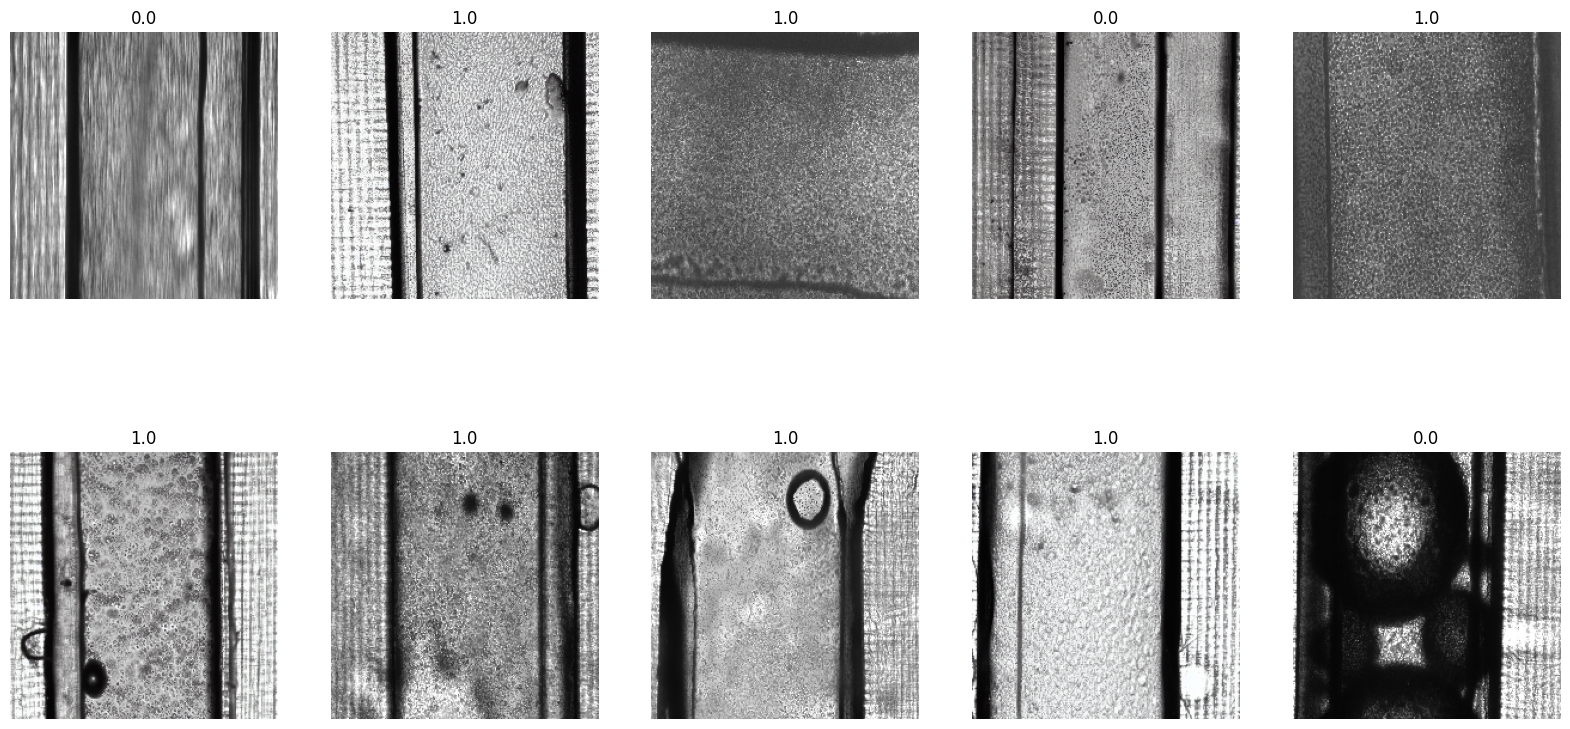

In [141]:
def plot_images(images, labels, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(str(labels[i]))
        plt.axis('off')
    plt.show()

# Retrieve one batch of data from the train, validation, or test generator
train_images, train_labels = next(train_generator)

# Assuming the data is structured as NumPy arrays and labels as numerical values or one-hot encodings
# If labels are one-hot encoded, convert to numerical labels
if train_labels.ndim > 1:
    train_labels = train_labels.argmax(axis=-1)

# Visualize 10 images from the batch
plot_images(train_images, train_labels, num_images=10)

In [142]:
#base_model = EfficientNetV2M(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, weights='imagenet')
# base_model = MobileNetV3Small(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 
#                               include_top=False,
#                               weights='imagenet'

# )
base_model = MobileNetV2(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 
                              include_top=False,
                              weights='imagenet'
)


base_model.trainable = False
#transfer learning un fine tuning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # For binary classification
    #layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
#base model true

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor, 'val_loss' or 'val_accuracy' are common options
    patience=10,          # Number of epochs to wait for an improvement before stopping
    restore_best_weights=True,  # Restore weights from the epoch with the best monitored metric
    verbose=1            # Verbosity level for logging the stopping action
)



In [143]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=75,  # Set a higher initial value, since EarlyStopping will stop early if needed
    callbacks=[early_stopping]
)
model.trainable = True

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=75,  # Set a higher initial value, since EarlyStopping will stop early if needed
    callbacks=[early_stopping]
)


# Step 5: Evaluation on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/75


c:\Users\Roberts\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


217/217 ━━━━━━━━━━━━━━━━━━━━ 215s 924ms/step - accuracy: 0.6023 - loss: 0.6709 - val_accuracy: 0.6573 - val_loss: 0.6293
Epoch 2/75
217/217 ━━━━━━━━━━━━━━━━━━━━ 171s 772ms/step - accuracy: 0.7556 - loss: 0.4951 - val_accuracy: 0.6958 - val_loss: 0.5840
Epoch 3/75
217/217 ━━━━━━━━━━━━━━━━━━━━ 169s 764ms/step - accuracy: 0.7953 - loss: 0.4455 - val_accuracy: 0.7168 - val_loss: 0.5620
Epoch 4/75
217/217 ━━━━━━━━━━━━━━━━━━━━ 170s 768ms/step - accuracy: 0.8098 - loss: 0.4068 - val_accuracy: 0.7238 - val_loss: 0.5485
Epoch 5/75
217/217 ━━━━━━━━━━━━━━━━━━━━ 170s 770ms/step - accuracy: 0.8480 - loss: 0.3577 - val_accuracy: 0.7308 - val_loss: 0.5441
Epoch 6/75
217/217 ━━━━━━━━━━━━━━━━━━━━ 169s 767ms/step - accuracy: 0.8453 - loss: 0.3465 - val_accuracy: 0.7273 - val_loss: 0.5312
Epoch 7/75
217/217 ━━━━━━━━━━━━━━━━━━━━ 169s 766ms/step - accuracy: 0.8812 - loss: 0.2970 - val_accuracy: 0.7308 - val_loss: 0.5244
Epoch 8/75
217/217 ━━━━━━━━━━━━━━━━━━━━ 169s 765ms/step - accuracy: 0.8827 - loss: 0.27

In [144]:
import pickle
saveLocation = MODEL_NAME + '_RD'  + str(REAL_DATA_PERCENT) + '_SD' + str(SYNTHETIC_DATA_PERCENT) + '_denoising' +SYN_HALU+ '_training_history.pkl'

history_dict = history.history
history_dict['test_loss'] = test_loss
history_dict['test_acc'] = test_acc

# Save the history.history dict to a pickle file
with open(saveLocation, 'wb') as f:
    pickle.dump(history_dict, f)

modelSave = MODEL_NAME + '_RD'  + str(REAL_DATA_PERCENT) + '_SD' + str(SYNTHETIC_DATA_PERCENT) + '_denoising' +SYN_HALU+ '_modelSave.h5'
model.save(modelSave)

In [145]:
import pickle

with open(saveLocation, 'rb') as f:
    loaded_history = pickle.load(f)
print(loaded_history)

{'accuracy': [0.6674834489822388, 0.7670798301696777, 0.8003747463226318, 0.8166618347167969, 0.846785843372345, 0.8555780053138733, 0.8725857734680176, 0.8862784504890442, 0.8962237238883972, 0.9045834541320801, 0.9093398451805115, 0.9208705425262451, 0.9259152412414551, 0.9387431740760803, 0.9347074031829834, 0.9384548664093018, 0.9476794600486755, 0.9541654586791992, 0.9571923017501831, 0.9631017446517944, 0.965552031993866, 0.9707408547401428, 0.9721822142601013, 0.974776566028595, 0.9753531217575073, 0.9773709774017334, 0.9815508723258972, 0.981839120388031, 0.9845777153968811, 0.9838570356369019, 0.9876044988632202, 0.9845777153968811, 0.985730767250061, 0.990775465965271, 0.9874603748321533, 0.9904871582984924, 0.9910637140274048, 0.988901674747467, 0.9913519620895386, 0.9930815696716309, 0.9923608899116516, 0.9940904974937439, 0.9927933216094971, 0.9916402697563171, 0.9942346215248108, 0.9956759810447693], 'loss': [0.6021853685379028, 0.4843054711818695, 0.43555355072021484, 0.